In [3]:
# Import all libraries
import glob 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Embedding,LSTM,Bidirectional,  Conv1D, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
from tensorflow import keras
import re
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
import pickle
from sklearn.metrics import precision_recall_fscore_support
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Data Pre-processing
def handle_emojis(tweet):
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', tweet) # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', tweet)           # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(<3|:\*)', ' EMO_POS ', tweet)                        # Love -- <3, :*   
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', tweet)              # Wink -- ;-), ;), ;-D, ;D, (;,  (-;  
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', tweet)       # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', tweet)               # Cry -- :,(, :'(, :"(     
    return tweet

def is_valid_word(word):
    return (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None)     # Check if word begins with an alphabet
    
def preprocess_word(word):
    word = word.strip('\'"?!,.():;')                                       # Remove punctuation
    word = re.sub(r'(.)\1+', r'\1\1', word)                                # Convert more than 2 letter repetitions to 2 letter 
    word = re.sub(r'(-|\')', '', word)                                     # Remove - & '
    return word

def preprocess_tweet(tweet):
  processed_tweet = []
  tweet = tweet.lower()                                                    # Convert to lower case
  tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' ', tweet)           # Convert to lower case
  tweet = re.sub(r'@[\S]+', ' ', tweet)                                    # Replace @handle with the word USER_MENTION
  tweet = re.sub(r'#', '', tweet)                                          # Replaces #hashtag with hashtag
  tweet = re.sub(r'\brt\b', '', tweet)                                     # Remove RT (retweet)
  tweet = re.sub(r'\.{2,}', ' ', tweet)                                    # Replace 2+ dots with space 
  tweet = tweet.strip(' "\'')                                              # Strip space, " and ' from tweet
  tweet = handle_emojis(tweet)                                             # Replace emojis with either EMO_POS or EMO_NEG
  tweet = re.sub(r'\s+', ' ', tweet)                                       # Replace multiple spaces with a single space 
  words = tweet.split()
  for word in words:
    word = preprocess_word(word)
    if is_valid_word(word):
      processed_tweet.append(word)
  clean_tweet = ' '.join(processed_tweet)
  return clean_tweet

In [5]:
df = pd.read_csv('Dataset.csv')  # Read csv file
df['Category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'Category_id']].drop_duplicates().sort_values('Category_id')
category_to_id = dict(category_id_df.values)                                 # Category to Id dictionary
id_to_category = dict(category_id_df[['Category_id', 'Category']].values)    # Id to Category dictionary
df.shape

(35514, 4)

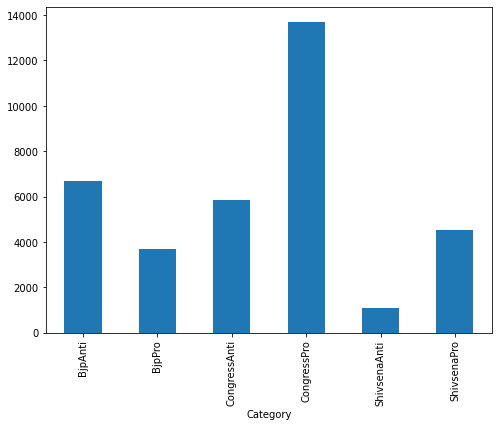

In [6]:
# Visualization of dataset
fig = plt.figure(figsize=(8,6))
df.groupby('Category').Tweets.count().plot.bar(ylim=0)
plt.show()

In [7]:
clean_tweet = []
for i in range(df.shape[0]):
  clean_tweet.append(preprocess_tweet(df['Tweets'][i]))
df['Clean_tweets'] = clean_tweet
print(df['Tweets'][10])
print(df['Clean_tweets'][10])

Riot Rewards: BJP's Vote Share Increases After Hindu-Muslim Clashes Riot Rewards: BJP's Vote Share Increases After Hindu-Muslim Clashes. A 1% increase in the number of riots in a district improves BJP's vote share by 4.4%. https://t.co/lbKqsRyVUz

riot rewards bjps vote share increases after hindumuslim clashes riot rewards bjps vote share increases after hindumuslim clashes a increase in the number of riots in a district improves bjps vote share by


In [8]:
# Split dataset into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(df['Clean_tweets'], df['Category_id'], train_size = 0.80, random_state = 0)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(28411,) (28411,)
(7103,) (7103,)


In [9]:
# Load Glove embeeding matrix
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [10]:
MAX_NB_WORDS = 50000                                            # The maximum number of words to be used. (most frequent)
MAX_SEQUENCE_LENGTH = 250                                       # Max number of words in each tweet.
EMBEDDING_DIM = 100                                             # Dimension of each words.
tokenizer = Tokenizer(num_words=MAX_NB_WORDS,  lower=True)
tokenizer.fit_on_texts(X_train.values)                          # Fit tokenizer on train data
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 32284 unique tokens.


In [11]:
# Convert words to token 
X_train = tokenizer.texts_to_sequences(X_train.values)
X_test = tokenizer.texts_to_sequences(X_test.values)
# Pad train and text data to MAX SEQUENCE LENGTH
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of Train tensor:', X_train.shape)
print('Shape of Test tensor:', X_test.shape)

Shape of Train tensor: (28411, 250)
Shape of Test tensor: (7103, 250)


In [12]:
# Convert categorical variable into dummy variables.
Y_train = pd.get_dummies(Y_train).values
Y_test = pd.get_dummies(Y_test).values

In [13]:
# Create a weight matrix for words in training docs
embedding_matrix = np.zeros((MAX_NB_WORDS, 100))
for word, index in tokenizer.word_index.items():
    if index > MAX_NB_WORDS - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [14]:
#CNN Model
def cnn_model():
  model_conv = Sequential()
  model_conv.add(Embedding(MAX_NB_WORDS, 100, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=True))
  model_conv.add(Dropout(0.2))
  model_conv.add(Conv1D(64, 5, activation='relu'))
  model_conv.add(MaxPooling1D(pool_size=4))
  model_conv.add(LSTM(100))
  model_conv.add(Dense(6, activation='sigmoid'))
  model_conv.compile(loss='binary_crossentropy', optimizer='adam',    metrics=['accuracy'])
  return model_conv

In [15]:
# Unidirectional LSTM Model
def unidirectional_lstm():
  model_glove = Sequential()
  model_glove.add(Embedding(MAX_NB_WORDS, 100, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=True))
  model_glove.add(Dropout(0.2))
  model_glove.add(LSTM(100, return_sequences=True))
  model_glove.add(LSTM(100))
  model_glove.add(Dense(6, activation='sigmoid'))
  model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model_glove

In [16]:
# BiDirectional LSTM Model
def bidirectional_model():
  model_glove = Sequential()
  model_glove.add(Embedding(MAX_NB_WORDS, 100, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=True))
  model_glove.add(Dropout(0.2))
  # model_glove.add(Bidirectional(LSTM(100), return_sequence = True))
  model_glove.add(Bidirectional(LSTM(100)))
  model_glove.add(Dense(6, activation='sigmoid'))
  model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model_glove.summary()
  return model_glove

In [17]:
# Instantiate and train model
model_glove = unidirectional_lstm()   # Modify this line to model_glove = cnn_model() or  model_glove = bidirectional_lstm()
epochs = 5                 # Number of epocs
batch_size = 32             # Size of batch
history = model_glove.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2)

Epoch 1/5
711/711 [==============================] - 53s 75ms/step - loss: 0.2353 - accuracy: 0.6814 - val_loss: 0.1440 - val_accuracy: 0.8279
Epoch 2/5
711/711 [==============================] - 52s 73ms/step - loss: 0.1163 - accuracy: 0.8596 - val_loss: 0.1139 - val_accuracy: 0.8638
Epoch 3/5
711/711 [==============================] - 52s 73ms/step - loss: 0.0759 - accuracy: 0.9132 - val_loss: 0.1083 - val_accuracy: 0.8749
Epoch 4/5
711/711 [==============================] - 52s 73ms/step - loss: 0.0517 - accuracy: 0.9435 - val_loss: 0.1075 - val_accuracy: 0.8795
Epoch 5/5
711/711 [==============================] - 51s 72ms/step - loss: 0.0371 - accuracy: 0.9604 - val_loss: 0.1144 - val_accuracy: 0.8751


In [20]:
model_glove.save('model')
pickle.dump(tokenizer, open("tokenizer.pickle", "wb")) # Save tokenizer using Pickle

INFO:tensorflow:Assets written to: /content/drive/My Drive/Btech Project/StageII/model/assets


In [22]:
# Get Precision, Recall and F-Score for test data
y_pred = model_glove.predict(X_test)
y_pred_idx = [np.where(row == np.max(row))[0][0] for row in y_pred ]
y_test_idx = [np.where(row == np.max(row))[0][0] for row in Y_test ]
val = precision_recall_fscore_support(y_test_idx, y_pred_idx, average='macro')
print("Precision : " + str(val[0]))
print("Recall : " + str(val[1]))
print("F-Score : " + str(val[2]))

Precision : 0.8672747533051144
Recall : 0.8631048938539766
F-Score : 0.8650292960375875


In [25]:
# Function to check political orientation of tweet
glove = keras.models.load_model('model')

def predict_orientation(tweet):
  tweet = preprocess_tweet(tweet)
  seq = tokenizer.texts_to_sequences([tweet])
  padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
  pred = glove.predict(padded)
  labels = ['BjpAnti', 'BjpPro', 'CongAnti', 'CongPro', 'ShivsenaAnti', 'ShivsenaPro']
  print(labels[np.argmax(pred)])

In [26]:
predict_orientation("Congress is worst party")

CongAnti
